<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2005%20-%20Feature%20Extraction/Lecture_05_Image_Descriptors_Texture_and_Others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMAGE DESCRIPTORS
In this notebook, we presented some shape and texture descriptors discussed during the class.  

After, we will apply the resulting features to a KNN classifier.

In [ ]:
import numpy as np
import cv2, math
import matplotlib.pyplot as plt
#Keras to import datasets, not for deep learning (yet)
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import skimage.feature as feature


In [ ]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles=None,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  if titles is None:
    titles = []
    A = ord('A')
    for i in range(n):
      titles.append(chr(A+i))

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [ ]:
!wget https://scikit-image.org/skimage-tutorials/_images/4_segmentation_15_0.png -O astronaut.png

Loading a sample image and rotate

In [ ]:
im = cv2.imread('astronaut.png',cv2.IMREAD_GRAYSCALE)
print(im.shape)
im = cv2.resize(im,(512,512))
print(im.shape)
flip_horiz = cv2.flip(im,1)
flip_vert = cv2.flip(im,0)
flip_both = cv2.flip(im,-1)
plot_sidebyside([im,flip_horiz,flip_vert,flip_both],
                ['Original','Flip Horizontal','Flip Vertical','Flip Both'],
                colormap='gray')

#Shape Descriptors

##Hu Moments
* Moments: Values that carry both spatial and intensity information (shape)
  * A weighted average of all pixel's intensities
  * *I(x,y)*: pixel coordinates of input *I*
  * Powers, *p* and *q*, are the weights of the horizontal and vertical dimensions

* Hu define 7 invariant moments

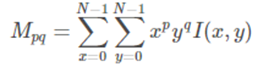

In [ ]:
class HuMoments:
  def describe(self,im,threshold=128):

    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)


    _,threshold = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY)

    # Calculate Moments
    moments = cv2.moments(threshold)
    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments)

    # Log scale hu moments
    for i in range(0,len(huMoments)):
      if huMoments[i] != 0:
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

    #There is resulting image for HuMoments
    return huMoments.reshape(huMoments.shape[0]), threshold

In [ ]:
desc = HuMoments()

for img in [im,flip_horiz,flip_vert,flip_both]:
  plt.figure(figsize=(6,4))
  plt.imshow(img,'gray')
  plt.axis('off')
  plt.show()
  moments = desc.describe(img)
  print(moments)



##HOG
HoG – Histogram of Oriented Gradients
* Computes the gradient and orientation of edges
* Use a kernel to compute the Gradients (i.e 9x1)
* Patch-Based Histogram (8x8, 16x16..)


In [ ]:
class HOG:
  def describe(self,im,pixels_per_cell=(8, 8),cells_per_block=(2, 2)):
    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im = cv2.resize(im,(64,128))

    fd, hog_image = feature.hog(im, orientations=9, pixels_per_cell=pixels_per_cell,
                	cells_per_block=(2, 2),visualize=True)
    return fd,hog_image

In [ ]:
desc = HOG()
for img in [im,flip_horiz,flip_vert,flip_both]:
  key_pts, hog_img = desc.describe(img)
  plot_sidebyside([img,hog_img],
                ['Input','HOG'],
                colormap='gray',
                figsize=(6,4))
  print(key_pts)

#Texture Descriptors

##GABOR Filters
  * Convolves the image using several Gaussian Kernels named Kernel Bank
  

In [ ]:
class GABOR:
    def __init__(self,ksize=31,n_filters=8):
        self.filters = []

        for theta in np.arange(0, np.pi, np.pi / n_filters):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            self.filters.append(kern)

    def get_filters(self):
      return self.filters

    def describe(self,im):
        if len(im.shape) > 2 and im.shape[2] == 3:
          im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

        gabor_img = np.zeros_like(im)
        for kern in self.filters:
            f_im = cv2.filter2D(im, cv2.CV_8UC3, kern)
            np.maximum(gabor_img, f_im, gabor_img)

        return gabor_img.reshape(-1), gabor_img

In [ ]:
desc = GABOR(16,8)
filters = desc.get_filters()
filters = np.array(filters)

plot_sidebyside(filters,colormap='gray')
for img in [im,flip_horiz,flip_vert,flip_both]:

  features,gabor_img = desc.describe(img)
  print(gabor_img.shape)
  plot_sidebyside([img,gabor_img],
                ['Input','Gabor'],
                colormap='gray',
                figsize=(8,6))


##LBP
* Convolves the image using a Circular Kernel
* The resulting pixel is computed in the binary neighborhood

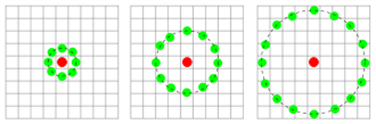

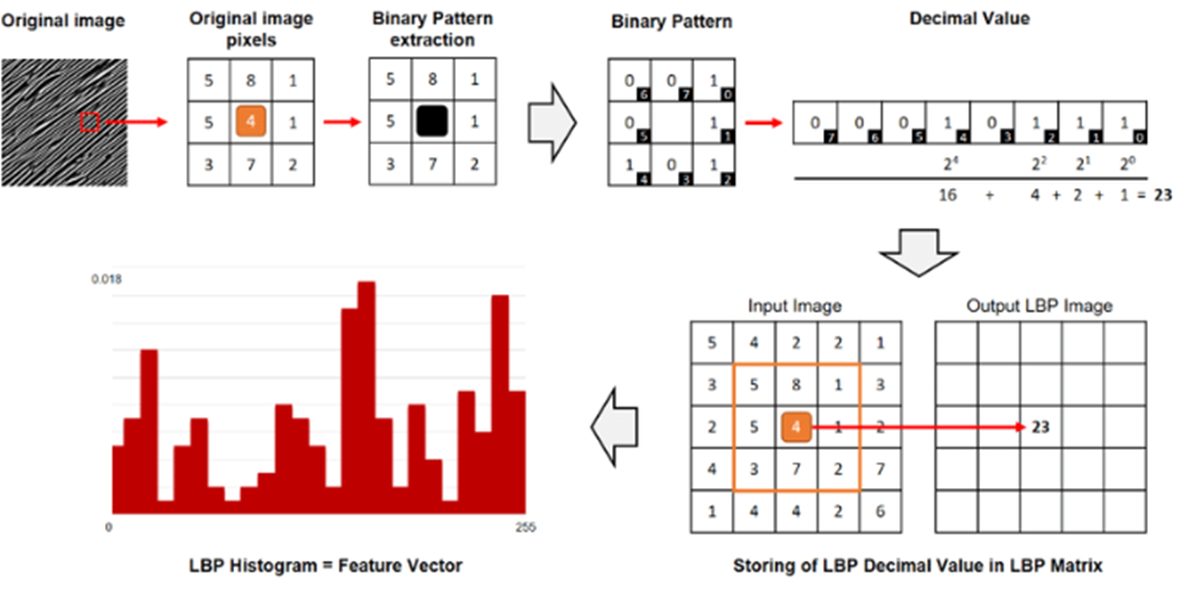

In [ ]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    if len(image.shape) > 2 and image.shape[2] == 3:
      image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    lbp_img = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp_img.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp_img

In [ ]:
desc = LocalBinaryPatterns(8, 2)
for img in [im,flip_horiz,flip_vert,flip_both]:
  hist, lbp_img = desc.describe(img)
  plot_sidebyside([img,lbp_img],
                ['Input','LBP'],
                colormap='gray',
                figsize=(12,8))
  print(hist)

#Plot ALL

In [ ]:
descriptors = []
descriptors.append(LocalBinaryPatterns(8, 2))
descriptors.append(HOG())
descriptors.append(HuMoments())
descriptors.append(GABOR(16,8))

desc_names = ['INPUT','LBP','HOG','Hu Moments','GABOR']
im = cv2.imread('astronaut.png',cv2.IMREAD_GRAYSCALE)
print(im.shape)
im = cv2.resize(im,(512,512))
print(im.shape)
imgs = [im]
for desc,names in zip(descriptors,desc_names):
  feat, res_img = desc.describe(im)
  print(feat.shape)
  imgs.append(res_img)

plot_sidebyside(imgs,desc_names,colormap='gray')

In [ ]:
def load_digit_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_fashion_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)
  return (x_train,y_train),(x_test, y_test),lbls_name

#Data Processing

In [ ]:
(x_train,y_train),(x_test, y_test),lbls_name = load_digit_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_fashion_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_cifar_10()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(y_train[0])

In [ ]:
descriptors = []
descriptors.append(LocalBinaryPatterns(8, 2))
descriptors.append(HOG())
descriptors.append(HuMoments())
descriptors.append(GABOR(16,8))

desc_names = [ 'INPUT','LBP','HOG','Hu Moments','GABOR']

for img, lbl in zip(x_train[:5],y_train[:5]):
  processed_imgs = [img]
  for desc in descriptors:
    feat, res_img = desc.describe(img)
    processed_imgs.append(res_img)

  plot_sidebyside(processed_imgs,desc_names,colormap='gray')



In [ ]:
descriptors = []
descriptors.append(LocalBinaryPatterns(8, 2))
descriptors.append(HOG())
descriptors.append(HuMoments())
descriptors.append(GABOR(16,8))

desc_names = ['LBP','HOG','HU','GABOR']

features_train = {}
features_test = {}

N_SAMPLES_TRAIN = 2000
N_SAMPLES_TEST = 400


for desc,name in zip(descriptors,desc_names):
  features = []
  for img, lbl in zip(x_train[:N_SAMPLES_TRAIN],y_train[:N_SAMPLES_TRAIN]):

    feat, _ = desc.describe(img)
    features.append(feat)

  #Add to a dictionary
  features_train[name] = np.reshape(features,(N_SAMPLES_TRAIN,-1))
  print('Train Data: ',name, features_train[name].shape)

for desc,name in zip(descriptors,desc_names):
  features = []
  for img, lbl in zip(x_test[:N_SAMPLES_TEST],y_test[:N_SAMPLES_TEST]):
    feat, _ = desc.describe(img)
    features.append(feat)

  #Add to a dictionary
  features_test[name] = np.reshape(features,(N_SAMPLES_TEST,-1))
  print('Test Data: ',name, features_test[name].shape)




#Data Normalization

In [ ]:
data = features_train['LBP']
print(data[0])
data_norm = preprocessing.StandardScaler().fit_transform(data)
print(data_norm[0])

#Data Reduction

In [ ]:
for name in desc_names:
  print("Name ", name)
  data = features_train[name]
  data_norm = preprocessing.StandardScaler().fit_transform(data)
  n_components = np.min(data_norm.shape)
  pca = PCA(n_components=n_components)
  reduced_data = pca.fit_transform(data_norm)
  percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cum_var_explained = np.cumsum(percentage_var_explained)

  plt.figure(figsize=(4, 3))
  plt.clf()
  plt.plot(cum_var_explained, linewidth=2)
  plt.title(name)
  plt.axis('tight')
  plt.grid()
  plt.xlabel('n_components')
  plt.ylabel('Cumulative_explained_variance')
  plt.show()


In [ ]:
n_features = {'LBP': 8, 'HOG': 120, 'HU': 6, 'GABOR': 450}
reduced_data_train = {}
reduced_data_test = {}
for name in desc_names:
  data = features_train[name]
  data_norm = preprocessing.StandardScaler().fit_transform(data)
  n_components = np.min(data_norm.shape)
  n_components=n_features[name]
  print(n_features[name])
  print('Computing PCA for ',name, 'with ', n_components, 'Components')

  pca = PCA(n_components=n_components)
  pca = pca.fit(data_norm)
  reduced_data_train[name] = pca.transform(data_norm)

  data = features_test[name]
  data_norm = preprocessing.StandardScaler().fit_transform(data)
  reduced_data_test[name] = pca.transform(data_norm)


#Classification

##Knn

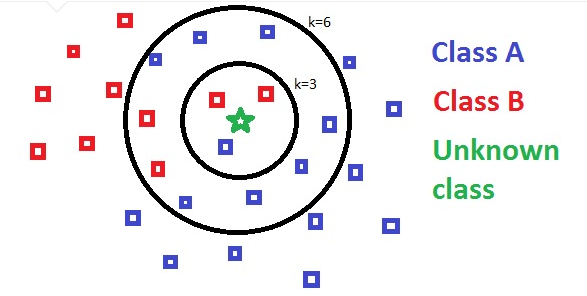

In [ ]:
def performance_evaluation(y_test, predictions,info_message):

  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predicted)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()

  id = np.random.randint(300)
  idx1,idx2=id,id+10
  diff = y_test - predictions
  idxs = np.where(diff == 0)

  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=(20, 10))
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f"Lbl: {lbl} Pred: {prediction}")

  idxs = np.where(diff != 0)


  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=(20, 10))
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f"Lbl: {lbl} Pred: {prediction}")

  plt.show()

In [ ]:
K = 5
for name in desc_names:

  train = features_train[name]
  test = features_test[name]

  print('Processing Full', name )
  print(train.shape,test.shape)
  knn = KNeighborsClassifier(n_neighbors=K)
  knn.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = knn.predict(test)

  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name)

  train = reduced_data_train[name]
  test = reduced_data_test[name]

  print('Processing Reduced', name )
  print(train.shape,test.shape)
  knn = KNeighborsClassifier(n_neighbors=K)
  knn.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = knn.predict(test)
  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name)